<a href="https://colab.research.google.com/github/sreent/machine-learning/blob/main/Final%20DNN%20Code%20Examples/ASL%20Sign%20Language/ASL%20Sign%20Language%20-%20Image%20Classification%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASL Sign Language - Image Classification Example

This notebook demonstrates the **Universal ML Workflow** applied to image classification using American Sign Language (ASL) hand gesture images.

## Learning Objectives

By the end of this notebook, you will be able to:
- Preprocess images for neural network input: **Color → Grayscale → Flatten**
- Understand how image data is represented as numerical arrays
- Build neural networks for multi-class **image classification**
- Apply the Universal ML Workflow to computer vision problems
- Evaluate classification performance with accuracy and confusion matrices

---

## Dataset Overview

| Attribute | Description |
|-----------|-------------|
| **Source** | ASL Sign Language Dataset |
| **Problem Type** | Multi-Class Classification (3 classes: A, B, C) |
| **Data Balance** | Balanced |
| **Data Type** | Unstructured (Images) |
| **Image Size** | Variable → Resized to 64×64 |
| **Preprocessing** | Color → Grayscale → Flatten to 1D (4096 features) |

---

## Image Preprocessing Pipeline

```
Original Image        Gray-Scale         Flattened
[H x W x 3]    →    [64 x 64]    →    [4096]
(Color RGB)         (Single channel)   (1D array for NN)
```

**Why flatten?** Dense neural networks expect 1D input vectors. We sacrifice spatial relationships for simplicity. (CNNs preserve spatial structure but are covered elsewhere.)

---

## 1. Defining the Problem and Assembling a Dataset

**Problem Statement:** Classify images of hand gestures into ASL letters (A, B, or C).

**Why this matters:**
- ASL recognition can help bridge communication gaps
- Image classification is foundational to computer vision
- This simplified 3-class problem demonstrates key concepts before tackling full 26-letter alphabet

<a href="https://colab.research.google.com/github/sreent/machine-learning/blob/main/Final%20DNN%20Code%20Examples/ASL%20Sign%20Language/ASL%20Sign%20Language%20-%20Image%20Classification%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASL Sign Language - Image Classification Example

This notebook demonstrates the **Universal ML Workflow** applied to a multi-class image classification problem using American Sign Language images.

## 2. Choosing a Measure of Success

Since this is a balanced 3-class problem, standard **accuracy** is meaningful. We also track:
- **Precision & Recall** per class
- **AUC** for overall discrimination
- **Confusion Matrix** to see which letters get confused

## 3. Deciding on an Evaluation Protocol

- **Hold-out Test Set (10%)**: Final evaluation
- **Validation Set**: Monitor training, early stopping
- **K-Fold Cross-Validation**: Hyperparameter tuning

## 4. Preparing Your Data

### 4.1 Import Libraries

We use `skimage` for image processing (grayscale conversion, resizing).

In [ ]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
from skimage.color import rgb2gray

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

# Keras Tuner for hyperparameter search
!pip install -q -U keras-tuner
import keras_tuner as kt

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [586]:
def get_image(file, size=(32, 32), gray=True) :
    img = Image.open(file_path)
    
    img = img.resize(size, Image.ANTIALIAS)
    
    if gray :
        img = rgb2gray(img)
    
    return np.array(img)

In [592]:
DATASET = 'asl'
IMAGE_SIZE = (32, 32)
SAMPLE_SIZE = 3000

images, labels = [], []
for folder in os.listdir(DATASET) :
    for file in os.listdir(DATASET + '/' + folder)[:SAMPLE_SIZE] :
        file_path = DATASET + '/' + folder + '/' + file
        
        image = get_image(file_path, size=IMAGE_SIZE, gray=True)
        images.append( image )
        
        labels.append(folder)
        
images = np.array(images)
labels = np.array(labels)

In [593]:
Xf = images.reshape((images.shape[0],-1))
yf = labels

In [594]:
TEST_SIZE = 0.15

(Xf_train, Xf_test, 
 yf_train, yf_test) = train_test_split(Xf, yf,  
                                       test_size=TEST_SIZE, stratify=yf,
                                       shuffle=True, random_state=SEED)

In [595]:
scaler = StandardScaler().fit(Xf_train)

X_train, X_test = scaler.transform(Xf_train), scaler.transform(Xf_test)

y_train, y_test = yf_train, yf_test

In [596]:
label_encoder = LabelEncoder()
label_encoder.fit(yf)

y_train = np_utils.to_categorical(label_encoder.transform(yf_train))
y_test = np_utils.to_categorical(label_encoder.transform(yf_test))

In [597]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 test_size=VALIDATION_SIZE, stratify=y_train,
                                                 shuffle=True, random_state=SEED)

##  Developing a model that does better than a baseline

In [598]:
len(yf[yf=='A']), len(yf[yf=='B']), len(yf[yf=='C']), len(yf[yf=='D'])

(3000, 3000, 3000, 0)

In [599]:
baseline = len(yf[yf=='A']) / len(yf)

baseline

0.3333333333333333

## 5. Developing a Model That Does Better Than a Baseline

**Baseline:** Random guessing with 3 balanced classes = 33.3% accuracy

In [602]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_CLASSES = y_train.shape[1]

OPTIMIZER = 'RMSprop'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = ['categorical_accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc', multi_label=True)]

In [ ]:
# Single Layer Perceptron (SLP) - No hidden layers
slp_model = Sequential([
    Dense(OUTPUT_CLASSES, activation='softmax', input_shape=(INPUT_DIMENSION,))
])
slp_model._name = 'Single_Layer_Perceptron'
slp_model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)

slp_model.summary()

In [ ]:
batch_size = 512
EPOCHS = 500

In [ ]:
# Train the SLP model
history_slp = slp_model.fit(X_train, y_train, batch_size=batch_size, epochs=EPOCHS, validation_data=(X_val, y_val), verbose=0)
slp_val_score = slp_model.evaluate(X_val, y_val, verbose=0)[1:]

In [ ]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(slp_val_score[0], baseline))
print('Precision (Validation): {:.2f}'.format(slp_val_score[1]))
print('Recall (Validation): {:.2f}'.format(slp_val_score[2]))
print('AUC (Validation): {:.2f}'.format(slp_val_score[3]))

In [612]:
def plot_training_history(history, monitors=['loss', 'AUC']) :

  # using the variable axs for multiple Axes
  fig, axs = plt.subplots(1, 2, sharex='all', figsize=(15,5))
 
  for ax, monitor in zip(axs.flat, monitors) :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    if monitor == 'loss' :
      monitor = monitor.capitalize()

    epochs = range(1, len(loss)+1)

    ax.plot(epochs, loss, 'b.', label=monitor)
    ax.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    ax.set_xlim([0, len(loss)])
    ax.title.set_text('Training and Validation ' + monitor + 's')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()
    ax.grid()

  _ = plt.show()

In [ ]:
plot_training_history(history_slp, monitors=['loss', 'auc'])

 ## Scaling up: developing a model that overfits

In [ ]:
# Multi-Layer Perceptron (MLP) - 1 hidden layer with 4 neurons
mlp_model = Sequential([
    Dense(4, activation='relu', input_shape=(INPUT_DIMENSION,)),
    Dense(OUTPUT_CLASSES, activation='softmax')
])
mlp_model._name = 'Multi_Layer_Perceptron'
mlp_model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS)

mlp_model.summary()

In [ ]:
# Train the MLP model
history_mlp = mlp_model.fit(X_train, y_train, batch_size=batch_size, epochs=750, validation_data=(X_val, y_val), verbose=0)
mlp_val_score = mlp_model.evaluate(X_val, y_val, verbose=0)[1:]

In [ ]:
plot_training_history(history_mlp, monitors=['loss', 'auc'])

In [ ]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(mlp_val_score[0], baseline))
print('Precision (Validation): {:.2f}'.format(mlp_val_score[1]))
print('Recall (Validation): {:.2f}'.format(mlp_val_score[2]))
print('AUC (Validation): {:.2f}'.format(mlp_val_score[3]))

## 6. Scaling Up: Developing a Model That Overfits

Adding hidden layers to increase model capacity for learning image patterns.

In [ ]:
# Hyperband Model Builder for ASL Classification
def build_model_hyperband(hp):
    """
    Build ASL model with FROZEN architecture (2 layers: 32 -> 16 neurons).
    Only tunes regularization (Dropout) and learning rate.
    """
    model = keras.Sequential()
    model.add(layers.Input(shape=(INPUT_DIMENSION,)))

    # Fixed architecture: 2 hidden layers with 32 and 16 neurons
    # Layer 1: 32 neurons
    model.add(layers.Dense(32, activation='relu'))
    drop_0 = hp.Float('drop_0', 0.0, 0.5, step=0.1)
    model.add(layers.Dropout(drop_0))

    # Layer 2: 16 neurons
    model.add(layers.Dense(16, activation='relu'))
    drop_1 = hp.Float('drop_1', 0.0, 0.5, step=0.1)
    model.add(layers.Dropout(drop_1))

    model.add(layers.Dense(OUTPUT_CLASSES, activation='softmax'))

    lr = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=LOSS_FUNC,
        metrics=METRICS
    )
    return model

In [ ]:
# Configure Hyperband tuner
tuner = kt.Hyperband(
    build_model_hyperband,
    objective='val_categorical_accuracy',
    max_epochs=20,
    factor=3,
    directory='asl_hyperband',
    project_name='asl_tuning'
)

In [ ]:
# Run Hyperband search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=batch_size
)

In [ ]:
# Get best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(f"  Dropout Layer 1: {best_hp.get('drop_0')}")
print(f"  Dropout Layer 2: {best_hp.get('drop_1')}")
print(f"  Learning Rate: {best_hp.get('lr')}")

## 7. Regularizing Your Model and Tuning Hyperparameters

Using **Hyperband** for efficient hyperparameter tuning with a frozen architecture.

### Why Hyperband?

**Hyperband** is more efficient than grid search because it:
1. Starts training many configurations for a few epochs
2. Eliminates poor performers early
3. Allocates more resources to promising configurations

This "early stopping" approach saves compute time while still exploring widely.

In [ ]:
# Build the best model with optimal hyperparameters
opt_model = tuner.hypermodel.build(best_hp)
opt_model.summary()

In [ ]:
# Train the best model
history_opt = opt_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=batch_size,
    verbose=1
)

trained_opt_model = {
    'model': opt_model,
    'val_score': opt_model.evaluate(X_val, y_val, verbose=0)[1:],
    'history': history_opt
}

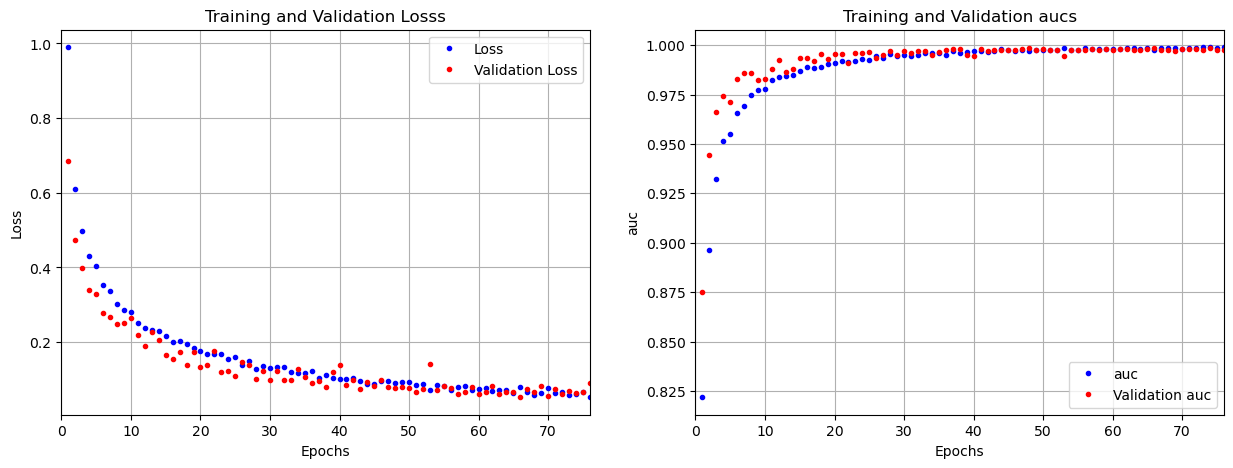

In [630]:
plot_training_history(trained_opt_model['history'], monitors=['loss', 'auc'])

In [631]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_opt_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_opt_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_opt_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_opt_model['val_score'][3]))

Accuracy (Validation): 0.99 (baseline=0.33)
Precision (Validation): 0.99
Recall (Validation): 0.99
AUC (Validation): 1.00


In [632]:
preds = trained_opt_model['model'].predict(X_test, verbose=0)

print('Accuracy (Test): {:.2f} (baseline={:.2f})'.format(accuracy_score(y_test.argmax(axis=1), 
                                                                      preds.argmax(axis=1)), baseline))
print('Precision (Test): {:.2f}'.format(precision_score(y_test.argmax(axis=1), 
                                                        preds.argmax(axis=1),
                                                        average='macro')))
print('Recall (Test): {:.2f}'.format(recall_score(y_test.argmax(axis=1), 
                                                  preds.argmax(axis=1),
                                                  average='macro')))
print('AUC (Test): {:.2f}'.format(roc_auc_score(y_test, 
                                                preds,
                                                multi_class='ovo',
                                                average='macro')))

Accuracy (Test): 0.99 (baseline=0.33)
Precision (Test): 0.99
Recall (Test): 0.99
AUC (Test): 1.00


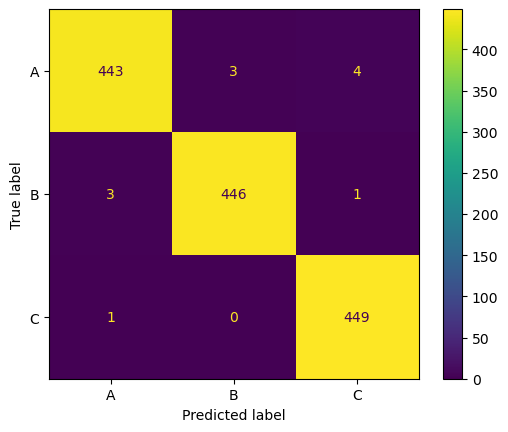

In [633]:
disp = ConfusionMatrixDisplay( confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1)),
                               display_labels=['A', 'B', 'C'])
_ = disp.plot()

---

## 8. Key Takeaways

1. **Image Preprocessing:** Color → Grayscale → Resize → Flatten → Normalize
2. **Flattening loses spatial information** - CNNs preserve it better
3. **Balanced classes** allow using standard accuracy metrics

## Appendix: Making the Code More Modular

The inline model creation and training code shown above is straightforward for learning purposes. For production code or larger projects, you may want to encapsulate this logic into reusable functions. Below are helper functions that wrap the model building and training steps.

In [ ]:
def build_classification_model(input_dim, output_classes, hidden_layers=None, 
                                optimizer='rmsprop', loss='categorical_crossentropy', 
                                metrics=['accuracy'], name=None):
    """
    Build a sequential classification model with optional hidden layers.
    
    Parameters
    ----------
    input_dim : int
        The number of input features.
    output_classes : int
        The number of output classes for classification.
    hidden_layers : list of int, optional
        List of neurons per hidden layer. If None or empty, creates an SLP.
        Example: [64, 32] creates two hidden layers with 64 and 32 neurons.
    optimizer : str or keras.optimizers.Optimizer
        The optimizer to use for training.
    loss : str or keras.losses.Loss
        The loss function for training.
    metrics : list
        List of metrics to track during training.
    name : str, optional
        Name for the model.
    
    Returns
    -------
    keras.Model
        A compiled Keras Sequential model.
    """
    model = Sequential()
    
    # Add hidden layers if specified
    if hidden_layers:
        for i, neurons in enumerate(hidden_layers):
            if i == 0:
                model.add(Dense(neurons, activation='relu', input_shape=(input_dim,)))
            else:
                model.add(Dense(neurons, activation='relu'))
    
    # Add output layer
    if hidden_layers:
        model.add(Dense(output_classes, activation='softmax'))
    else:
        model.add(Dense(output_classes, activation='softmax', input_shape=(input_dim,)))
    
    if name:
        model._name = name
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


def train_model(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=100):
    """
    Train a Keras model and return the training history and validation scores.
    
    Parameters
    ----------
    model : keras.Model
        A compiled Keras model.
    X_train : array-like
        Training features.
    y_train : array-like
        Training labels.
    X_val : array-like
        Validation features.
    y_val : array-like
        Validation labels.
    batch_size : int
        Number of samples per gradient update.
    epochs : int
        Number of epochs to train the model.
    
    Returns
    -------
    tuple
        (history, val_score) where history is the training history object
        and val_score is the list of validation metric values (excluding loss).
    """
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        verbose=0
    )
    val_score = model.evaluate(X_val, y_val, verbose=0)[1:]
    return history, val_score


# Example usage:
# 
# # Build an SLP (no hidden layers)
# slp = build_classification_model(
#     input_dim=INPUT_DIMENSION,
#     output_classes=OUTPUT_CLASSES,
#     hidden_layers=None,
#     optimizer=OPTIMIZER,
#     loss=LOSS_FUNC,
#     metrics=METRICS,
#     name='SLP_Model'
# )
# 
# # Build an MLP with 2 hidden layers
# mlp = build_classification_model(
#     input_dim=INPUT_DIMENSION,
#     output_classes=OUTPUT_CLASSES,
#     hidden_layers=[64, 32],
#     optimizer=OPTIMIZER,
#     loss=LOSS_FUNC,
#     metrics=METRICS,
#     name='MLP_Model'
# )
# 
# # Train the model
# history, val_score = train_model(mlp, X_train, y_train, X_val, y_val, batch_size=512, epochs=500)
# print(f"Validation Accuracy: {val_score[0]:.2f}")